# Project Group - 15
Members: 

         Guoheng Li 5939259

         Junpeng Li 5921856

         Haosen Luo 5936195
         
         Chenwei Peng 591838


# Research Objective

## Objective

Based on its importance, a variety of car following models are put forward trying to model such phenomenon. However, different models are based on different assumptions, formulations and methodologies, which entails real-world data to test their limitations and advantages, for instance, some of them can't account for some specific car following patterns. Nowadays, with preprocessed real-world car following data, we are able to calibrate the car following phenomana better and more precisely.
Therefore, in this project the objectives are:

1. Are there correlations among some car following variables(e.g.headway, follower's velocity and acceleration)? How are the IDM and Gipps models formulated?

2. Can these models be implemented? How to estimate the parameters? Are there some pros and cons between these two models? How can we possibly further improve these two models?


1. 0值为什么出现这么多
2. 如何可视化体现不同模式的划分
3. 速度和理想速度的比值

# Contribution Statement

Work in Process

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**: Guoheng Li

**Author 2**: Junpeng Li

**Author 3**: Chenwei Peng

**Author 4**: Haosen Luo


# 1. Introduction

Researching car following models is critical in transportation engineering and urban planning. These models provide insights essential for congestion management, infrastructure planning, environmental impact assessment, and safety improvement. By understanding traffic dynamics, decision-makers can optimize traffic flow, identify congestion-prone areas, and design efficient road networks. This leads to reduced emissions, energy conservation, and increased road safety. Traffic flow models also aid in public transportation optimization, enhancing services for commuters. They support data-driven decision-making and offer economic benefits by improving productivity and reducing fuel consumption. In essence, traffic flow models are invaluable tools that inform decisions, ultimately shaping sustainable urban development and improving overall quality of life.

# 2. Data

## 2.1 Data Used

In this project, we used car-following datasets provided in [this paper](https://arxiv.org/pdf/2305.18921.pdf), which is originally collected by autonomous vehicles (AVs) from the open Lyft level-5 dataset to study car-following behavior in mixed traffic flow. The dataset consisted of over 29,000 HV-following-AV (H-A) and 42,000 HV-following-HV (H-H) car-following segments. The dataset includes over 1000 hours of perception and motion data collected over a 4-month period from urban and suburban environments along a fixed route in Palo Alto, California. The dataset comprises approximately 170,000 scenes, with each scene spanning approximately 25 seconds. Each scene includes the movement states of perceived vehicles, cyclists, and pedestrians, as well as the position and orientation of the autonomous vehicle (AV). 

Then, data is processed using a data processing framework that involved several steps. First, CF pairs and their raw trajectories were selected from the unlabelled dataset based on certain rules. Then, the raw data quality was assessed through anomaly analysis. The next step involved enhancing the raw data. For AVs, missing segments were filled and smooth position and speed were estimated. For HVs, missing data around 0-speed points was filled using a jerk-minimization method. Finally, vehicle size processing was performed to split the enhanced dataset into two groups: H-A and H-H.

The result of data processing was an enhanced dataset that had higher quality and covered diverse regimes for calibrating car-following models. The enhanced data showed a reduction in anomalies, particularly in abnormal jerk sign inversion. This processed dataset can be further used for investigating car-following behavior in mixed urban traffic and the impact of AVs on traffic.

With diverse algorithms, we have obtained the data of the regime of each vehicle from an enhanced dataset. In the dataset of regime of each vehicle pairs, we have considered 7 regimes: 
  1. free acceleration (Fa)
  2. free deceleration not caused by the leading vehicle (Fd)
  3. cruising at a desired speed (C)
  4. acceleration following a leading vehicle (A)
  5. deceleration following a leading vehicle (D)
  6. constant speed following (F)
  7. standstill (S)

The dataset also provides the time duration of each regime as well as the combination for each car-following case id which is for further analysis.

**All the steps above are already done before dataset published, thus how to impletement these process is out of scope of our project, our project focuses on visualization, modelling and calibration on car following models, using the processed data**


## 2.2 Data Preprocessing Pipeline

### 2.2.1 data processing
We will clean the data, reduce data noise, and improve the quality of the data, making it more suitable for subsequent analysis or modeling tasks.

### 2.2.2 Data sorting
We will classify the following 7 modes based on size, centroid, acceleration and velocity: free acceleration (Fa), free deceleration not caused by the leading vehicle (Fd), cruising at a desired speed (C), acceleration following a leading vehicle (A), deceleration following a leading vehicle (D), constant speed following (F), and standstill (S).

## 3 Pipeline

### 3.2.1 data exploration and plotting
In order to explore the relations between the given car following dataset and the common car following models, and to derive some inspirations on how these models are developed, we resort to data exploration methods to help analyzing. 

Here are several ways to perform calculations on data：
- Headspace：The distance between the heading of the front car and the rear car.
- Vehicle distance: The distance from the rear bumper of the front vehicle to the front of the rear vehicle.
- Effect of size on distance：Effect of vehicle size on distance between vehicles.
- Statistics: Variance / mean.
- Analyze different regimes: Relationships between vehicle attributes.
By analylising these 

### 3.2.2 Modelling
We will apply the Intelligent Driver Model and Gipps Model to verify their applications on different regimes, and try analysing their behaviour patterns as well pros and cons. However, to do so there are some parameters left to be filled in. Therefore, we have to calibrate the parameters first objectively and comprehensively, i.e. we decided to calibrate the parameters by using algorithms to minimize the total car following trajectory loss, and apply them to different regimes due to the huge discrepancy among various patterns.


![IMAGE](./images/image.png)

# 4. Data Exploration

In [3]:
# import dependent libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# DIRECTORIES
PROJECT_FILE = "D:\DATA\TIL6022"

## 4.1 对数据进行描述

### 4.1.1 相关系数图
最intuitive的想法（不用分类）

1. v和车头间距的关系 / a和车头间距的关系
2. ...balabala

### 4.1.2 直方图

1. 速度，加速度，车头间距做频率分布直方图分析（对不同的regimes）

- 为什么会出现那么多0?

2. 车辆size的直方图

### 4.1.3 饼图

1. HH HA 分开探讨 不同regimes下的数量占比

## 4.2 数据关系分析

1. 为什么要划分ADF....这些模式： 通过直方图来反映各个量看看有没有区别

2. IDM模型需要至少ADF的数据，那么IDM模型是怎么构建的，参数之间有什么关系（可以直接用ADF数据）:
    - 车头间距和加速度的关系
    - 速度和理想速度的比值（？）（分场景ADF+1 / ADF / ADF+2）的差距会对加速度有什么影响

## 4.1 Data visualization and analysis before modelling

### 4.1.1 Vehicle Size Distribution Description
1） The Vehicle Length Frequency Distribution chart depicts the frequency distribution of vehicles of different lengths. The vehicle length ranges from 0 meters to approximately 17.5 meters. Most vehicles fall within the range of 2.5 meters to 7.5 meters, with the highest frequency observed between 2.5 meters and 5.0 meters, surpassing 1400 vehicles. This indicates that the majority of vehicles are relatively short, likely small or compact cars.

2）Vehicle Length Category Histogram
This graph illustrates the number of vehicles in different length categories. Among these categories, "Compact (4.4-6)" has the highest count, with a total of 2378 vehicles, while "Mini (3-3.5)" has the fewest, with only 16 vehicles. Compact category vehicles are the most prevalent, while Mini category vehicles are the least common. It is evident that the number of Compact and Small category vehicles significantly exceeds other categories in the dataset under study, indicating that these two vehicle types are the most commonly observed.

The data from both charts complement each other, providing a comprehensive view of vehicle lengths and their distribution.

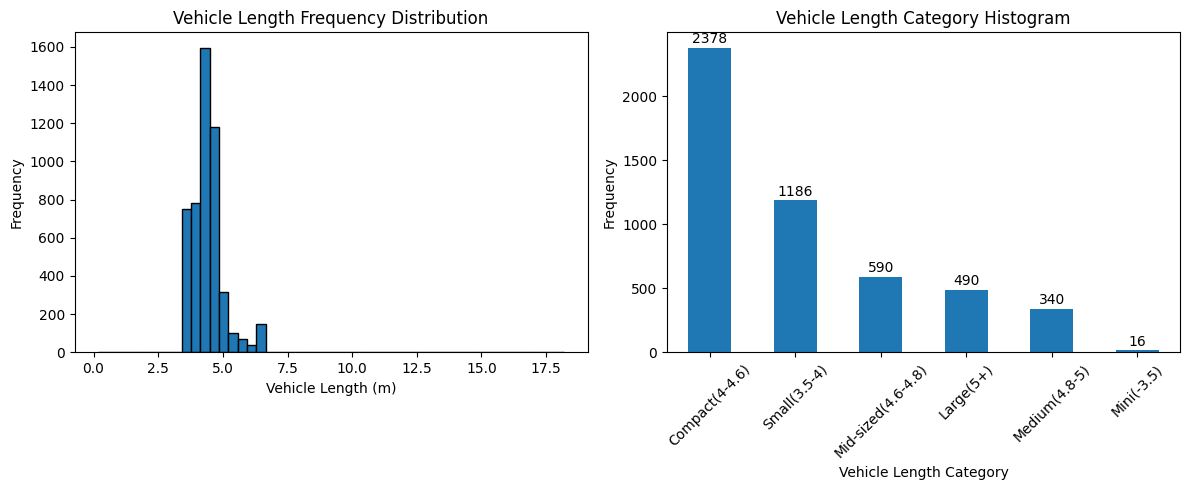

### 4.1.2 Speed Distribution Histograms for Following Vehicles in Different Modes
In ADF Mode:
This chart displays the speed distribution of vehicles. The distribution forms a distinct bell-shaped curve, concentrated between -0.5 (representing measurement errors) and 0.25 m/s². This indicates that in the basic ADF mode, the variation in vehicle speed acceleration is very small, with most vehicles maintaining a stable speed.

In ADF+1 Mode:
The speed distribution ranges from 0 to 20 m/s. The data distribution is relatively uniform, with no pronounced peaks, but there is a slight elevation between 5 m/s and 7.5 m/s. This suggests that in this mode, vehicle speed selection is relatively balanced, with no specific concentration trend.

In ADF+2 Mode:
The speed distribution also ranges from 0 to 20 m/s. Similarly, there are no very distinct peaks, but the data is slightly concentrated between 5 m/s and 10 m/s. This indicates that in this mode, vehicles tend to travel at moderate speeds.

In ADF+3 Mode:
The speed distribution ranges from 0 to 20 m/s. The data distribution is somewhat scattered, but the speed selection is more concentrated between 5 m/s and 10 m/s. This suggests that in the ADF+3 mode, vehicles also tend to favor moderate speeds.

In ADF+4 Mode:
The speed distribution ranges from 0 to 10 m/s. The distribution in this chart is more scattered, with no clear concentration trend. A possible explanation is that in ADF+4 mode, vehicle speed selection is more flexible and lacks specific preferences.
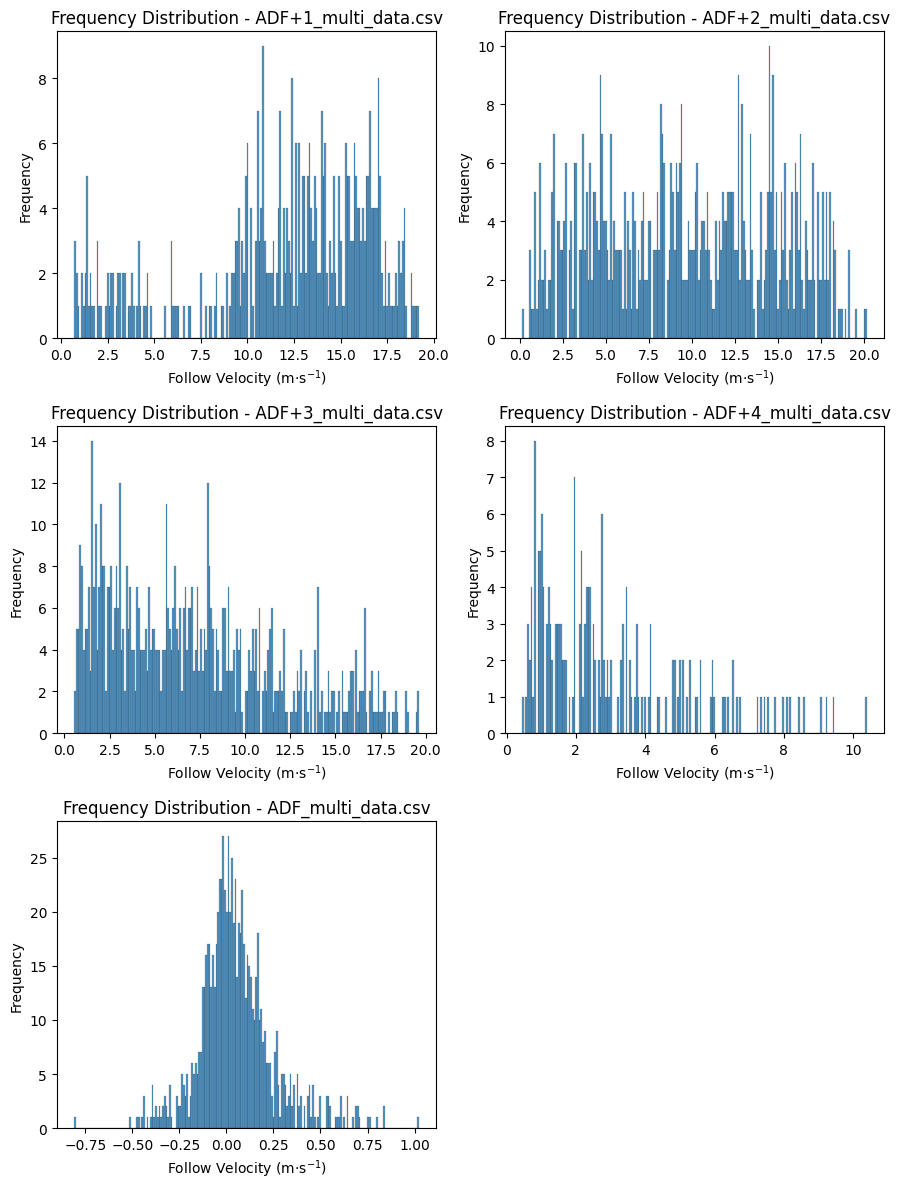

### 4.1.3 Acceleration Distribution Histograms for Following Vehicles in Different Modes

In ADF Mode:
This is the most concentrated distribution among all the modes, with acceleration primarily concentrated between -0.25 and 0.25. This indicates that in the basic ADF mode, the variation in vehicle acceleration is very small, with almost no significant positive or negative acceleration.

In ADF+1 Mode:
Acceleration is primarily concentrated between -0.25 and 0.25. The chart shows a clear peak near 0, indicating that in ADF+1 mode, the acceleration of most vehicles is very close to 0. The frequency of positive or negative accelerations gradually decreases, suggesting that in this mode, vehicle acceleration changes are minimal.

In ADF+2 Mode:
The distribution in this chart is similar to ADF+1, but the central peak slightly favors positive acceleration. The frequency is slightly higher around 0, which may suggest that in ADF+2 mode, more vehicles choose to accelerate slightly.

In ADF+3 Mode:
The acceleration distribution in this mode appears to be more varied. While there is still a central peak, the frequency distribution on both sides is more balanced. This may indicate that in ADF+3 mode, there is greater variability in vehicle acceleration.

In ADF+4 Mode:
This chart displays a more distinct bimodal distribution, with one peak near 0 and another peak near 0.5. This might suggest that in ADF+4 mode, vehicles either maintain stability or choose a higher level of acceleration.

Overall, as the mode changes from ADF to ADF+4, the trend in vehicle acceleration variation gradually increases. The basic ADF mode exhibits the most stable driving behavior, while ADF+3 and ADF+4 modes allow for more significant acceleration variations.
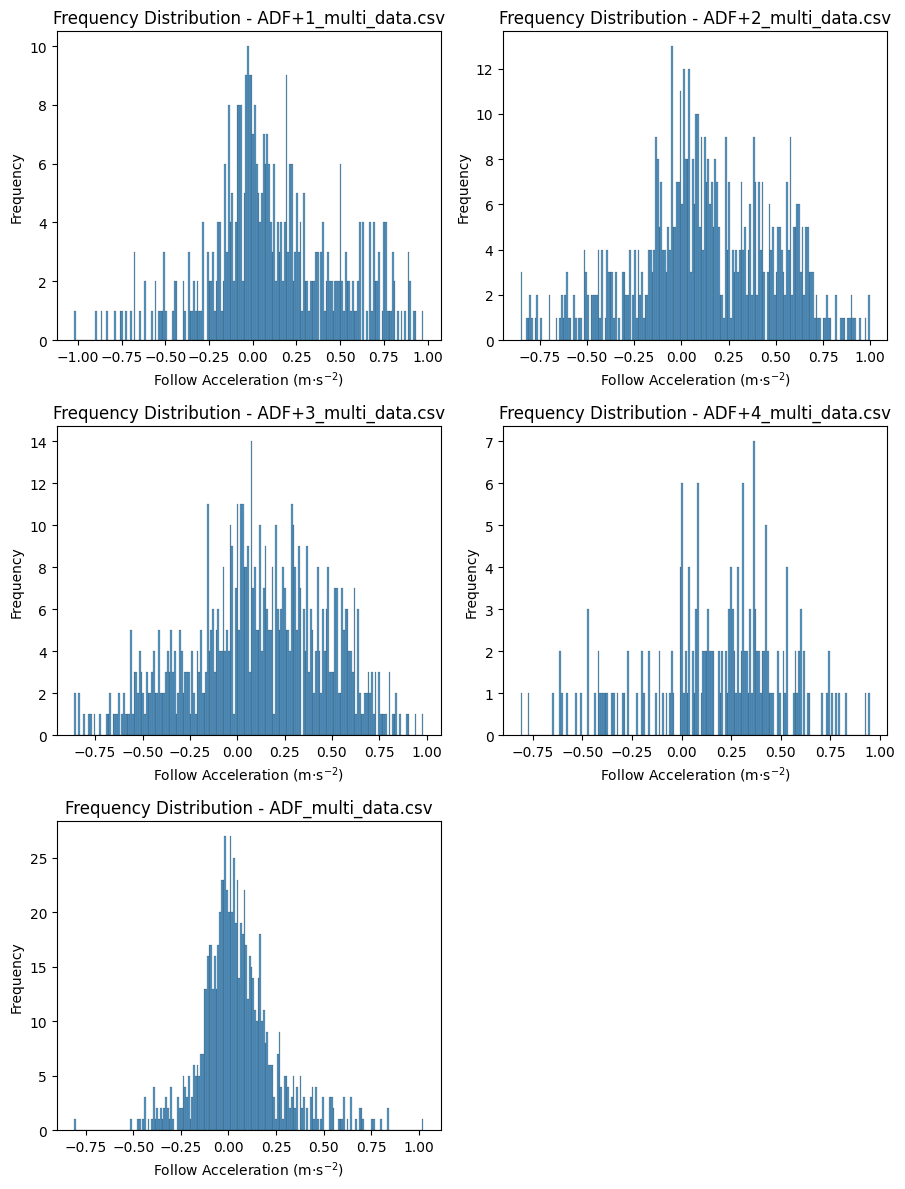

### 4.1.4 Relationship between Following Vehicle Speed and Headway

These charts illustrate the relationship between the headway (gap between vehicles) and the average speed of following vehicles.

In ADF+1 Mode:
Most data points cluster between headways of 0-30 meters and speeds of 5-15 meters per second. The distribution of following vehicle speeds appears to be most concentrated within headways of 10-30 meters. As the headway increases, there is a trend of increased speed for following vehicles.

In ADF+2 Mode:
The distribution of data points is similar to the first chart, but within headways of 10-20 meters, the speed distribution is even more concentrated. When the headway is between 0-20 meters, the speeds of following vehicles are primarily concentrated between 5-15 meters per second. The trend is similar to the first chart, with an increase in speed as the headway widens.

In ADF+3 Mode:
The distribution of data points is similar to the previous two charts, but more data points cluster within headways of 0-20 meters and speeds of 5-10 meters per second. In this chart, headways of 10-20 meters seem to result in a tighter distribution of following vehicle speeds. The trend is consistent with the previous two charts, showing an increase in speed as the headway widens. These charts all demonstrate a certain relationship between headway and following vehicle speed, where an increase in headway is associated with an increase in following vehicle speed.

In ADF Mode:
Most data points cluster within headways of 0-25 meters and speeds of 0-15 meters per second. When the headway is between 5-20 meters, the distribution of following vehicle speeds seems more concentrated. The trend is consistent, with an increase in speed as the headway widens.

In ADF+4 Mode:
Data points predominantly focus on headways of 0-30 meters and speeds of 0-20 meters per second. Within headways of 10-25 meters, the speed of following vehicles displays a more concentrated distribution. Like the other charts, an increase in headway results in an increase in following vehicle speed.

From these charts, it is evident that as the headway increases, there is a trend of increased speed for following vehicles. This may indicate that drivers tend to accelerate when they have more space ahead of them. This is intuitive, as more significant space provides drivers with more time to react, making them feel safer to accelerate. Data points are primarily concentrated in areas with smaller headways and lower speeds. This might suggest that in situations of heavy traffic or when drivers need to maintain lower speeds, headways between vehicles tend to be smaller.

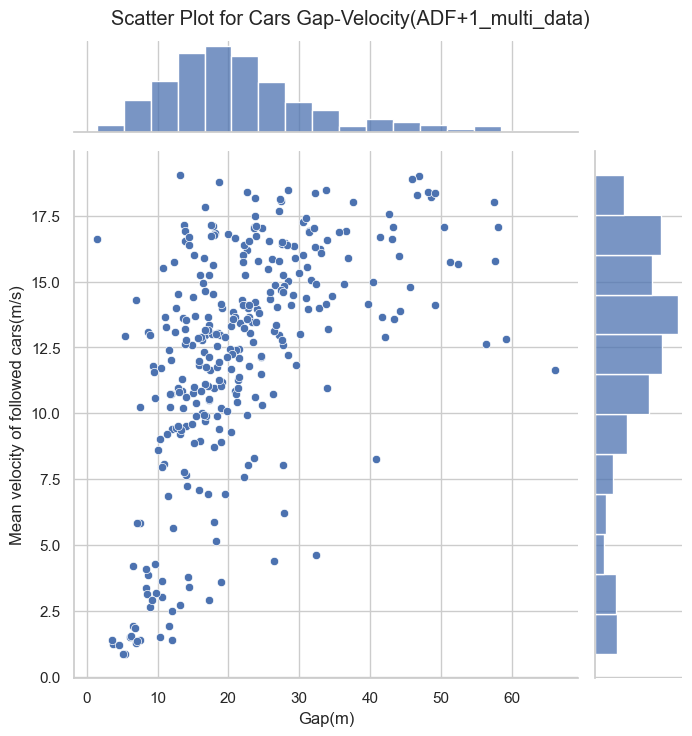
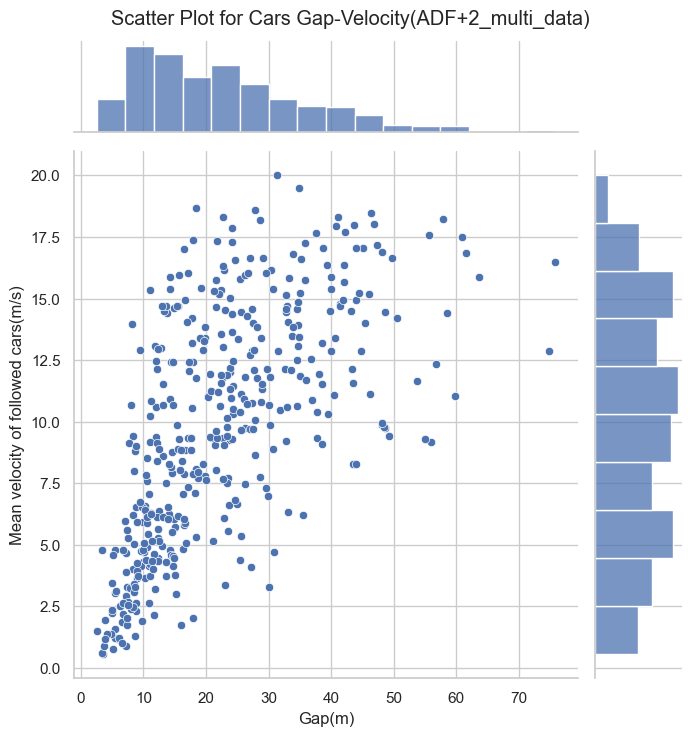
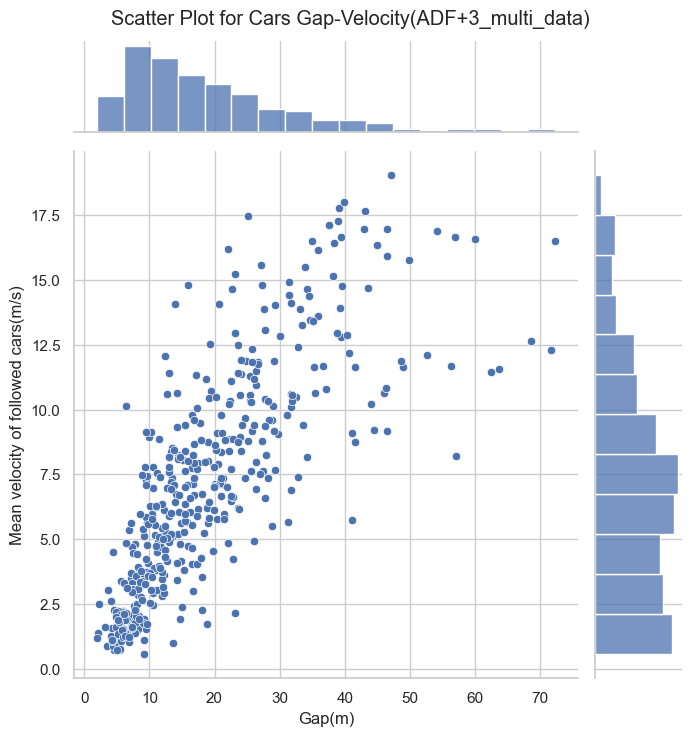
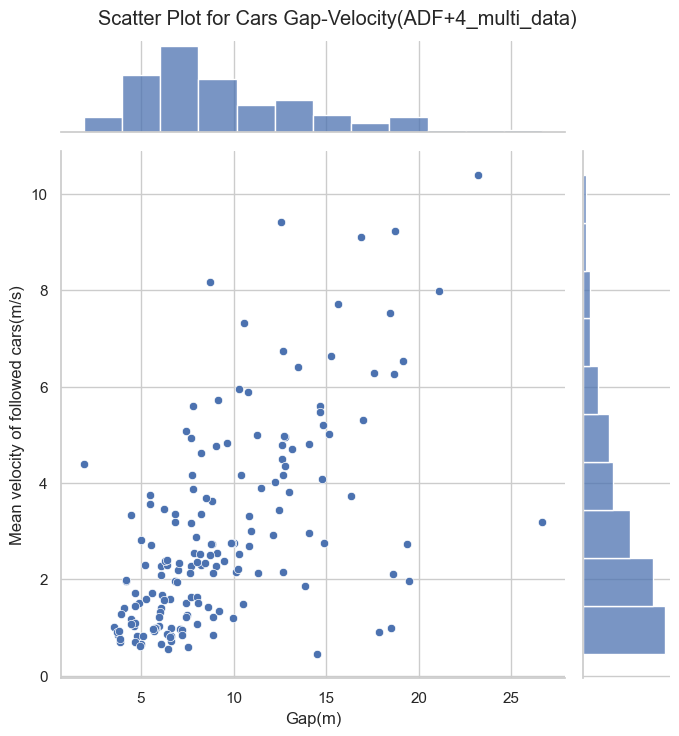
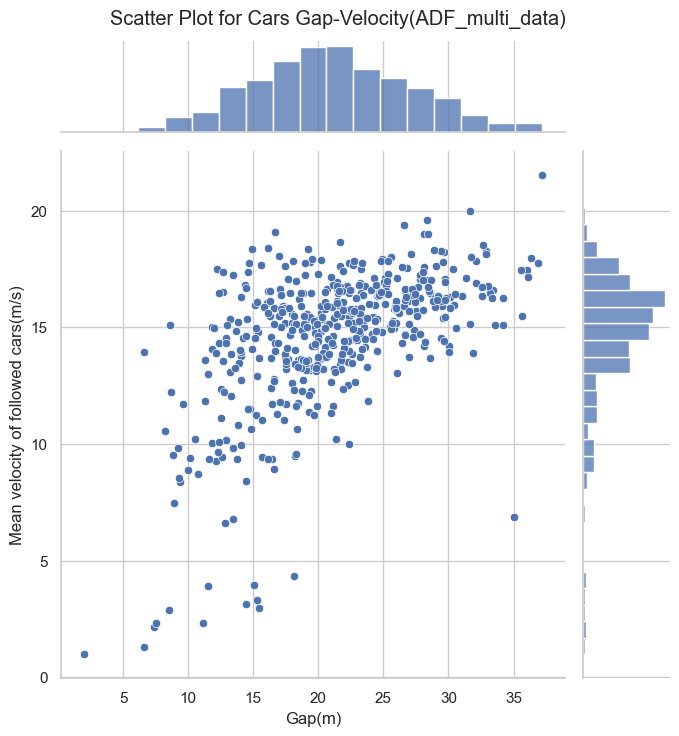

### 4.1.5 Translation: Scatter Plots of Speed and Corresponding Acceleration for Different Vehicles
1. Scatter Heatmap for Lead Cars' Velocity-Acceleration:
This chart illustrates the relationship between the velocity of lead cars (Lead Velocity) and their acceleration (Lead Acceleration). The velocity ranges from 0 to approximately 25, while the acceleration ranges from approximately -7.5 to 10. The densest data points are concentrated in the region of low velocity and acceleration close to 0. This indicates that in such scenarios, most lead cars maintain a steady speed with minimal acceleration or deceleration. As velocity increases, the distribution of acceleration becomes wider, suggesting that at higher speeds, driver reactions and decisions become more varied.

2. Scatter Heatmap for Follow Cars' Velocity-Acceleration:
This chart depicts the relationship between the velocity of follow cars (Follow Velocity) and their acceleration (Follow Acceleration). The velocity range is the same as in the lead cars' chart, while the acceleration range is slightly smaller, ranging from approximately -6 to 8. The data distribution is similar to that of the lead cars' chart, with the densest data points also concentrated in the region of low velocity and acceleration near 0. This suggests that follow cars also tend to maintain a steady speed at these lower velocities. In comparison to lead cars, the acceleration distribution of follow cars at higher speeds is slightly more concentrated, indicating that follow cars exhibit more conservative driving behavior at higher speeds.

Both charts indicate that at lower speeds, most vehicles tend to maintain a steady speed with minimal acceleration or deceleration. Lead cars exhibit a relatively broader acceleration distribution at higher speeds, while follow cars show a more concentrated acceleration distribution at the same speeds. This may reflect the more conservative driving behavior of follow cars when traveling at higher speeds. Overall, both charts demonstrate stability in vehicle behavior at lower speeds and reveal different driving behavior patterns at higher speeds.
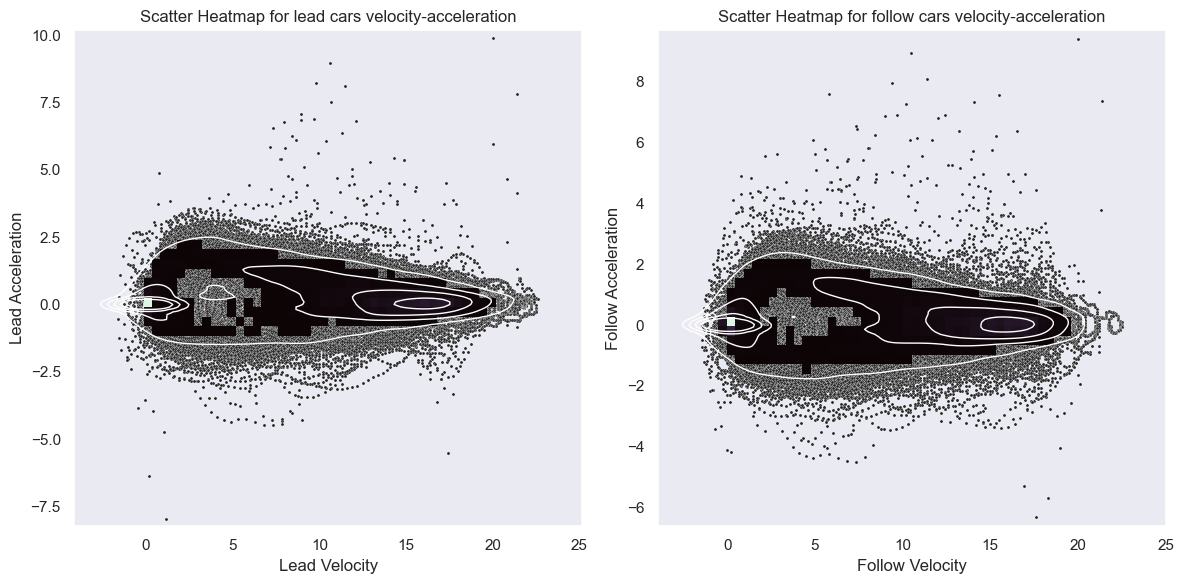

# 5. Models, Calibrations & Pros and Cons

While there are many available models for car following, different kinds of models account for different behaviours. Based on the data exploration and the conclusion we made in the last part:
- 1
- 2
- 3

In recent studies, common car following models we are to discuss, are usually devided into 3 types.

## 5.1 Models

### 5.1.1 Desired Measures Models (Intelligent Driver Model)

The model presumes that each driver has a desired velocity, headway, and the drivers try to minimize the gap between the actual value and the desired value, while constrained by a variety of conditions, for instance safety distances. Intelligent Driver Model(IDM) is catagorized in this catagorization:

Drivers try to minimize the following distance, and minimize both the speed difference and desired headway as well. In IDM model:

1. The influence factors include own speed $v$, the bumper-to-bumper gap $s$ to the lead vehicle, and the difference of the speed $\Delta v = v - v_{\text{lead}}$

2. The model only outputs the acceleration $a$ on the following car.

3. The model parameters are driving styles.


The IDM model equations are fomulated as follows:
$$
\begin{aligned}
&\frac{dv}{dt} = a\left[1 - \left(\frac{v}{v_0}\right)^\sigma - \left(\frac{s^*(v, \Delta v)}{s}\right)^2 \right]\\

&s^*(v, \Delta v) = s_0 + \max\left[0, \left(vT+\frac{v\Delta v}{2 \sqrt{ab}}\right)\right]
\end{aligned}
$$




where,
- $\frac{dv}{dt}$ is the acceleration the follower vehicle will achieve in the next timestep.
- $a$ is the desired acceleration.
- $b$ is the desired deceleration.
- $v$ is the velocity of the follower in the current timestep.
- $v_0$ is the desired velocity of the follower.
- $s$ is the front-to-rear gap between 2 vehicles, which can be calculated by $x_\text{lead}(t)-x_\text{follow}(t) - \frac{1}{2}(l_\text{lead} + l_\text{follow})$
- $s^*(v,\Delta v)$ is the desired dynamical gap.


In [4]:
class Car:
    
    def __init__(self, size: float, xs: np.array = [], vs: np.array = [], a_s: np.array = []) -> None:
        self.vs = vs  # a list consist of all velocities in all timesteps.
        self.xs = xs
        self.a_s = a_s
        self.size = size

In [6]:
## IDM models with arbitary parameters

class IDM:
    
    def __init__(self, param: dict) -> None:
        ## dict = {v0, s0, T, a, b}
        self.v0 = param['v0']  # the velocity the vehicle would drive at in free traffic
        self.s0 = param['s0'] # a minimum desired net distance.
        self.T = param['T'] # the minimum possible time to the vehicle in front
        self.a = param['a'] # the maximum vehicle acceleration
        self.b = param['b'] # a positive number (comfortable breaking deceleration)
        self.sigma = 4 # exponent factor, usually set to 4

    def get_desired_s(self, v_this, delta_v_i):
        
        desired_s = v_this * self.T + v_this * delta_v_i / (2 * np.sqrt(self.a * self.b))
        return self.s0 + max(0, desired_s)
    
    def get_new_a(self, v_this, v_front, s_this):
        
        delta_v_i = v_this - v_front
        return self.a * (1 - np.power(v_this / self.v0, self.sigma) 
                            - np.power((self.get_desired_s(v_this, delta_v_i) / s_this), 2))
    
    def update(self, lead_car: Car, this_car: Car, time_step: float):
        """
            
        """
        assert this_car is not None
        
        N = len(lead_car.xs)
        
        for i in range(1, N):
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]
            
            gap_now = lead_s_now - this_s_now - 1/2(lead_car.size + this_car.size)  # the distance is head's distance
            this_v_a = self.get_new_a(this_v_now, lead_v_now, gap_now)
            # update
            if this_v_now + this_v_a * time_step < 0:
                this_car.vs.append(0)
            else:
                this_car.vs.append(this_car.vs[i - 1] + time_step * this_v_a)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step + 1 / 2 * this_v_a * pow(time_step, 2))
            this_car.a_s.append(this_v_a)

### 5.1.2 Gipps' Model

Gipps' model is the most popular safety distance model, which assumes that the speeid is selected by the driver to ensure the safety between two vehicles can be held.
Gipps' model includes two modes of driving: free-flow and CF. The Gipps Model equations are formulated as follows:

$$
V(t+\tau) = \min\left\{
    
    \begin{aligned}
    &V(t) + 2.5a_0\tau(1-V(t)/V^*)(0.025V(t)/V^*)^{1/2}\\
    &b_0\tau + \sqrt{b_0^2 \tau^2 - b_0[2s(t)-V(t)\tau - \frac{V'(t)^2}{b_0}]}
    \end{aligned}
    
    
    \right.
$$

due to the different mechanism under these two models, we apply different symbols and notations to describe them.
in above models:
- $\tau$ is the reacting time. usually is $0.2$(s)
- $a_0$ is the max acceleration that a vehicle can achieve.
- $b_0$ is the min acceleration that a vehicle can achieve.
- $V(t)$ is the velocity of the following vehicle at time $t$.
- $V^*$ is the desired speed that the following vehicle want to achieve (i.e. in free flow mode)
- $s(t)$ is the distance to the rear of the front vehicle $x_\text{lead}(t)-x_\text{follow}(t) - \frac{1}{2}(l_\text{lead} + l_\text{follow})$, due to the $x$ here is the centroid of a vehicle.

In [7]:
## Gipps model

class Gipps:
    
    def __init__(self, param) -> None:
        self.rect_time = param["rect_time"]
        self.max_b = param["max_b"]
        self.max_a = param["max_a"]
        self.v0 = param["v0"]


    def update(self, lead_car: Car, this_car: Car, time_step: float):
        
        N = len(lead_car.xs)
        this_car.a_s = None  # Gipps model doesn't need a for estimating
        
        for i in range(1, N):
            
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]

            gap_now = lead_s_now - this_s_now - 1/2(lead_car.size + this_car.size)

            this_v = min(- self.max_b * self.rect_time + np.sqrt(pow(self.max_b, 2) * pow(self.rect_time, 2) + self.max_b * (2*(gap_now)- self.rect_time * this_v_now + pow(lead_v_now, 2)/self.max_b)),
                        this_v_now + 2.5 * self.max_a * self.rect_time * (1 - this_v_now / self.v0) * pow((0.025 + this_v_now / self.v0), 2))

            this_car.vs.append(this_v)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step)

        

### 5.1.3 Visualization for Models

Even though the two models above are formualted in the form of continuous time domain, in order to simulate the car-following models on computer, we have to assume that the domain is discrete.

According to the dataset, the timestep is set to be $0.1$ (s) for each entry of data. Thus, we decide to conform to that convention.

In [ ]:

CARS = np.loadtxt(PROJECT_FILE + "data.csv", delimiter=",")
SIZES = np.loadtxt(PROJECT_FILE + "size.csv", delimiter=",")
test_scenes = []
sizes = []
for i in range(1000):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))
    sizes.append(CARS[np.where(CARS[:, 0] == i), :])


test_scene = test_scenes[31]

print("TOTAL TIME STEP: %d" %test_scene.shape[0] )


car_front = Car(sizes[i][1], test_scene[:, 1], test_scene[:, 3], test_scene[:, 3])

car_follow = Car(sizes[i][2], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])

car_follow_real = Car(sizes[i][2], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])

param = {
    "rect_time": 0.2,
    "max_b": 2,
    "max_a": 2
}

gipps = Gipps(param)

gipps.update(car_front, car_follow, 0.1)

print(car_follow.xs)
print(car_front.xs)
print(car_follow_real.xs)


plt.plot(car_front.xs, label="1")
plt.plot(car_follow.xs, label="2")
plt.plot(car_follow_real.xs[0], label="3")
plt.legend()
plt.show()

## 5.2 Calibration



After deriving the models, we have to calibrate their parameters with real world data to improve their performance. However, calibrating the parameters with the real-life data is not a easy thing. 

First, Based on the research of Anshuman[2], in order to calibrate the IDM model, the data are required to meet the completeness condition, i.e. one scenario consists of at least A(Acceleration), D(Deceleration) and F(Following) regimes.
Therefore, in the data preprocessing stage, we already split the data into ADF, ADF+1, ADF+2 and ADF+n for further process.

Second, the popular calibration methods is Genetic Algorithms(GA), which is a method for solving optimization problems that is based on natural selection, the process that drives biological evolution. After achieving the optimal value for minimizing the loss function (which we will define later) on the train dataset, it's safe to identify that they are the approximate optimal set of parameters, due to the GA is an evolutionary algorithms, which determines that the solution it provides is local optimal, instead of global optimal.


In [ ]:
## import dependencies

from sko.GA import GA 

# Constant values

NUM_TEST = 100
FILE_DIR = "D:\DATA\TIL6022\data.csv"

In [ ]:
def _single_test(test_scene, model):

    car_front = Car(sizes[i][1], test_scene[:, 1], test_scene[:, 3], test_scene[:, 3])

    car_follow = Car(sizes[i][2], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])

    car_follow_real = Car(sizes[i][2], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])

    LENGTH = len(car_front.xs)

    model.update(car_front, car_follow, 0.1)
    
    return np.sqrt(1 / LENGTH * np.sum(np.square([x1 - x2 for x1, x2 in zip(car_follow_real.xs[0], car_follow.xs)])))


def fitness(param_set):
    global CARS, test_scenes

    param = {
                "v0": param_set[0],
                "s0": param_set[1] / 100,
                "T": param_set[2] / 100,
                "a": param_set[3] / 100,
                "b": param_set[4] / 100,
                "sigma": 4
                }

    errors = []
    
    model = ()

    for i in range(NUM_TEST):
        test_scene = test_scenes[i]
        errors.append(_single_test(test_scene, model))

    return np.mean(errors)

In [ ]:


CARS = np.loadtxt(FILE_DIR, delimiter=",")
test_scenes = []
for i in range(NUM_TEST):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))


ga = GA(func=fitness, n_dim=5, size_pop=50, max_iter=20, prob_mut=0.01, lb=[5, 10, 30, 1, 10], ub=[40, 400, 200, 600, 600], precision=1)
result = ga.run()
print(result)

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

# 6. Limitations and further research

# References

1. [Large Car-following Data Based on Lyft level-5 Open Dataset: Following Autonomous Vehicles vs. Human-driven Vehicles. Guopeng Li, Yiru Jiao, Victor L. Knoop, Simeon C. Calvert, and J.W.C. van Lint](https://arxiv.org/pdf/2305.18921.pdf)
